## Self-practice task: Logistic regression using PyMC

We are going to try to classify irises. Recall that it has 4 real valued features.


In [1]:
! sudo apt-get update
! sudo apt-get install texlive-latex-recommended
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
! unzip -o type1cm.zip -d /tmp/type1cm
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
! sudo texhash
!apt install cm-super
!pip install latex
!pip install bayesian-optimization

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,393 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,556 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-u

In [2]:
# Import necessary libraries
import pymc as pm
import warnings
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

### Loading data

1-  Load the Iris dataset and select only the first two classes and take only the first two features.
2- draw a scatter plot to check that selected classes are linearly separable.

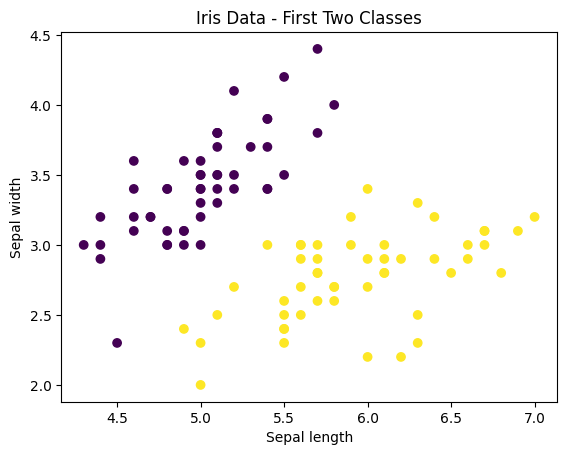

In [3]:
# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data[iris.target != 2, :2]  # Only take the first two features
y = iris.target[iris.target != 2]  # Only take the first two classes

# Visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('Iris Data - First Two Classes')
plt.show()


In [4]:
assert X.shape == (100, 2), "X should have 100 samples and 2 features"
assert y.shape == (100,), "y should have 100 samples"

### Define Logistic regression model


1. Select a prior distribution for the intercept to be normal with mean 0 and variance 100.
2. Select a prior distribution for the coefficients to be normal with mean 0 and variance 100 (notice that we have 2 of them, so we have to take it into account somehow. Documentation of `pm.Normal` might be useful).
3. Compute the linear `mu`. Hint: you might need to check `pm.math` documentation.
4. Choose the right distribution for logits. Don't forget to set the parameter `observed`.


In [5]:


with pm.Model() as logistic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)

    # Linear model
    mu = alpha + pm.math.dot(X, beta)

    # Likelihood
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    y_obs = pm.Bernoulli('y_obs', p=theta, observed=y)

    # Inference
    trace_logistic = pm.sample(2000, return_inferencedata=True)


In [6]:
assert trace_logistic is not None, "Trace should not be None"

### Visualize the model and make sure that it looks correctly.


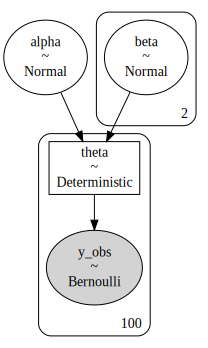

In [7]:
pm.model_to_graphviz(logistic_model)


### Fit the model and check the posterior distributions.


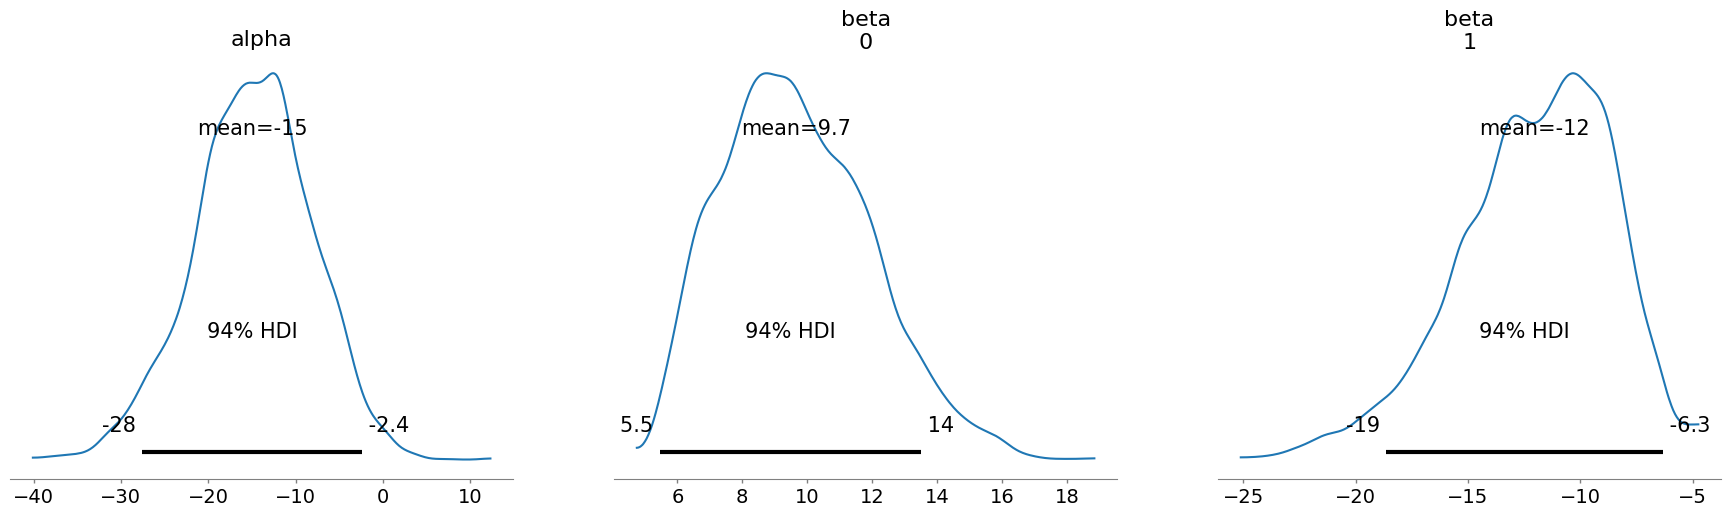

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha   -14.934  6.735 -27.547   -2.367      0.238    0.168     803.0   
beta[0]   9.667  2.266   5.472   13.510      0.124    0.088     307.0   
beta[1] -12.059  3.407 -18.637   -6.313      0.196    0.139     237.0   

         ess_tail  r_hat  
alpha       983.0    1.0  
beta[0]     347.0    1.0  
beta[1]     115.0    1.0  


In [16]:
# Plot posterior distributions
pm.plot_posterior(trace_logistic, var_names=['alpha', 'beta'])
plt.show()

# Check the model summary, explicitly include 'beta'
summary = pm.summary(trace_logistic, var_names=['alpha', 'beta'])
print(pm.summary(trace_logistic, var_names=['alpha', 'beta']))




### Use the fitted model to make predictions on the training data and visualize the decision boundary.


In [ ]:
# Generate predictions
with logistic_model:
    pm.set_data({"X": X})
    posterior_predictive = pm.sample_posterior_predictive(trace_logistic)

# Visualize the decision boundary
xx, yy = np.meshgrid(np.linspace(X[:, 0].min()-0.5, X[:, 0].max()+0.5, 100),
                     np.linspace(X[:, 1].min()-0.5, X[:, 1].max()+0.5, 100))
grid = np.c_[xx.ravel(), yy.ravel()]

with logistic_model:
    pm.set_data({"X": grid})
    pred = pm.sample_posterior_predictive(trace_logistic, var_names=["y_obs"], samples=500)

pred_mean = pred["y_obs"].mean(axis=0).reshape(xx.shape)

plt.contourf(xx, yy, pred_mean, levels=[0, 0.5, 1], alpha=0.2, cmap='viridis')
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='viridis')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('Decision Boundary')
plt.show()


KeyError: 'X'